In [11]:
import import_ipynb

import os

import torch
import numpy as np
import PIL.Image as pil_image

from model import SRCNN
from utils import convert_rgb_to_ycbcr, convert_ycbcr_to_rgb, calc_psnr

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [8]:
if __name__ == '__main__':
    weights_file = "/output/best.pth"
    image_file = "/data/super-resolution/91_data/zebra.bmp"
    scale = 3
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = SRCNN().to(device)
    
    state_dict = model.state_dict()
    
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)    
    
    
    model.eval()
    
    image = pil_image.open(image_file).convert('RGB')
    
    image_width = (image.width // scale) * scale
    image_height = (image.height // scale) * scale
    
    image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
    image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
    image = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
    image.save(image_file.replace('.', 'bicubic_x{}.'.format(scale)))
    
    image = np.array(image).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(image)

    y = ycbcr[..., 0] 
    y /= 255.
    y = torch.from_numpy(y).to(device)
    y = y.unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        preds = model(y).clamp(0.0, 1.0)

    psnr = calc_psnr(y, preds)
    print('PSNR: {:.2f}'.format(psnr))

    preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

    output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
    output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
    output = pil_image.fromarray(output)
    output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))

    
    

PSNR: 31.19


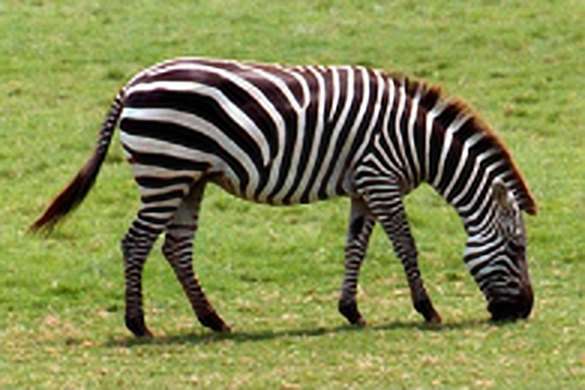

In [17]:
pil_image.open("/data/super-resolution/91_data/zebra_srcnn_x3.bmp")

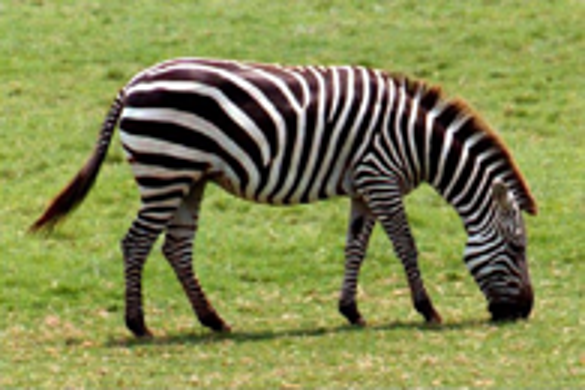

In [18]:
pil_image.open("/data/super-resolution/91_data/zebrabicubic_x3.bmp")